# **Dynamic Routing Between Capsules**

Sabour, S., Frosst, N., & Hinton, G. E. (2017). Dynamic routing between capsules. arXiv preprint arXiv:1710.09829.

Ref.

*https://github.com/naturomics/CapsNet-Tensorflow*

*https://jayhey.github.io/deep%20learning/2017/11/28/CapsNet_1/*

## **Default Setting**

In [30]:
import tensorflow as tf

import datetime
import os

%load_ext tensorboard

print(f"tf.__version__: {tf.__version__}")

tf.__version__: 2.4.1


## **Load Dataset**

In [2]:
## Load MNIST dataset.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

## Print the shapes.
print(f"x_train.shape: {x_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"x_test.shape: {x_test.shape}")
print(f"y_test.shape: {y_test.shape}")

11493376/11490434 [==============================] - 0s 0us/step
x_train.shape: (60000, 28, 28)
y_train.shape: (60000,)
x_test.shape: (10000, 28, 28)
y_test.shape: (10000,)


In [3]:
@tf.function
def tr_rescale(images, labels):
    images = tf.expand_dims(images, axis = -1)
    images = tf.image.convert_image_dtype(images, tf.dtypes.float32)
    labels = tf.cast(labels, tf.dtypes.int32)
    return (images, labels), (labels, images)

@tf.function
def ts_rescale(images):
    images = tf.expand_dims(images, axis = -1)
    images = tf.image.convert_image_dtype(images, tf.dtypes.float32)
    return images

In [4]:
BATCH_SIZE = 1024
AUTO = tf.data.experimental.AUTOTUNE ## -1


## Train & test split.
NUM_TEST_SIZE = 10_000

tr_X, vl_X = x_train[NUM_TEST_SIZE:], x_train[:NUM_TEST_SIZE]
tr_Y, vl_Y = y_train[NUM_TEST_SIZE:], y_train[:NUM_TEST_SIZE]


## Make tf.data.Dataset.
tr_dataset = tf.data.Dataset.from_tensor_slices((tr_X, tr_Y)
                        ).cache(
                        ).shuffle(100_000,
                        ).batch(BATCH_SIZE
                        ).map(tr_rescale, num_parallel_calls = AUTO
                        ).prefetch(AUTO)

vl_dataset = tf.data.Dataset.from_tensor_slices((vl_X, vl_Y)
                        ).cache(
                        # ).shuffle(100_000,
                        ).batch(BATCH_SIZE
                        ).map(tr_rescale, num_parallel_calls = AUTO
                        ).prefetch(AUTO)

ts_dataset = tf.data.Dataset.from_tensor_slices((x_test,)
                        # ).cache(
                        # ).shuffle(100_000,
                        ).batch(BATCH_SIZE
                        ).map(ts_rescale, num_parallel_calls = AUTO
                        ).prefetch(AUTO)

## Print the shapes.
print(f"tr_dataset.element_spec: {tr_dataset.element_spec}")
print(f"vl_dataset.element_spec: {vl_dataset.element_spec}")
print(f"ts_dataset.element_spec: {ts_dataset.element_spec}")

tr_dataset.element_spec: ((TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None)), (TensorSpec(shape=(None,), dtype=tf.int32, name=None), TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)))
vl_dataset.element_spec: ((TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None)), (TensorSpec(shape=(None,), dtype=tf.int32, name=None), TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)))
ts_dataset.element_spec: TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)


## **Create Network**

In [22]:
def PrimaryCaps(
    num_capsules = 32,
    vec_dims = 8,
    kernel_size = 9,
    strides = 2,
    padding = "valid",
    model_name = None,
):
    """
        inputs : [batch, 20, 20, 256]
        outputs: [batch, 6 * 6 * 32, 8]
         - 6 * 6 * 32 = # of capsules (in total)
         - 8 = # of property of each capsule.
    """
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(num_capsules * vec_dims, 
                               kernel_size,
                               strides = strides, 
                               padding = padding,
                               activation = "relu"),
        tf.keras.layers.Reshape((-1, vec_dims))], name = model_name)


def squashing(vectors):
    normed_vectors = tf.norm(vectors, axis = 2, keepdims = True)
    return normed_vectors ** 2 / (1 + normed_vectors ** 2) * (vectors / normed_vectors)


class Routing(tf.keras.layers.Layer):

    def __init__(
        self,
        dim_outputs = 16,
        num_outputs = 10,
        num_routing = 3,
        name = None,
    ):
        super(Routing, self).__init__()

        self.dim_outputs = dim_outputs
        self.num_outputs = num_outputs
        self.num_routing = num_routing


    def get_config(
        self
    ):
        config = super(Routing, self).get_config().copy()
        config.update({
            "dim_outputs" : self.dim_outputs,
            "num_outputs" : self.num_outputs,
            "num_routing" : self.num_routing})
        
        return config


    def build(
        self,
        input_shape,
    ):
        ## W.shape == [1152, 8, 16]
        self.W = self.add_weight(shape = (input_shape[1], self.num_outputs, input_shape[2], self.dim_outputs),
                                 initializer = "glorot_uniform", 
                                 trainable = True, 
                                 name = "W")
        
        ## Initialize every bias as zero.
        self.b = self.add_weight(shape = (input_shape[1], self.num_outputs),
                                 initializer = tf.keras.initializers.Zeros(),
                                 trainable = True,
                                 name = "b")


    def call(
        self,
        u,
    ):
        ## u_hat_j|i = W_ij @ u_i
        ##  - output: [batch, 1152, 10, 16, 1]
        u = tf.tile(tf.expand_dims(u, axis = 2), [1, 1, self.num_outputs, 1])
        u = tf.expand_dims(u, axis = -1)

        u_hat = tf.matmul(self.W, u, transpose_a = True)

        ## Procedure 1: Line 3
        for _ in range(self.num_routing):
            ## Procedure 1: Line 4
            ##  - output: [1152, 10]
            c = tf.nn.softmax(self.b, axis = 1)

            ## Procedure 1: Line 5
            ##  - output: [batch, 10, 16, 1]
            s = tf.math.reduce_sum(c[..., tf.newaxis, tf.newaxis] * u_hat, axis = 1)
            
            ## Procedure 1: Line 6
            ##  - output: [batch, 10, 16, 1] 
            v = squashing(s)

            ## Procedure 1: Line 7 (scalar product)
            agreement = tf.matmul(u_hat, tf.expand_dims(v, axis = 1), transpose_a = True)
            agreement = tf.math.reduce_mean(agreement, axis = [0, -1, -2])

            self.b.assign_add(agreement)

        return v[..., 0] ## squeezing


class Mask(tf.keras.layers.Layer):

    def __init__(
        self,
        num_labels = 10,
        name = None,
    ):
        super(Mask, self).__init__()

        self.num_labels = num_labels


    def get_config(
        self,
    ):
        config = super(Mask, self).get_config().copy()
        config.update({
            "num_labels" : self.num_labels})
        
        return config


    def call(
        self,
        x,
        y,
    ):
        y = tf.expand_dims(tf.one_hot(y, depth = self.num_labels), axis = -1)
        return tf.matmul(x, y, transpose_a = True)[..., 0] ## Squeeze

In [23]:
def Encoder(
    model_name = "Encoder",
):
    x = model_input = tf.keras.layers.Input(shape = (28, 28, 1), dtype = tf.dtypes.float32)

    x = tf.keras.layers.Conv2D(256, 9, activation = "relu")(x)

    x = PrimaryCaps(model_name = "PrimaryCaps")(x)
    model_output = Routing(name = "DigitCaps")(x)

    return tf.keras.Model(
        inputs = model_input,
        outputs = model_output,
        name = model_name)
    

def Decoder(
    model_name = "Decoder",
):
    x = model_input = tf.keras.layers.Input(shape = (10, 16), dtype = tf.dtypes.float32)
    y = model_label = tf.keras.layers.Input(shape = (), dtype = tf.dtypes.int32)
    
    x = Mask()(x, y)

    x = tf.keras.layers.Dense(512, activation = "relu")(x)
    x = tf.keras.layers.Dense(1024, activation = "relu")(x)
    x = tf.keras.layers.Dense(28 * 28, activation = "sigmoid")(x)

    model_output = tf.keras.layers.Reshape((28, 28, 1))(x)

    return tf.keras.Model(
        inputs = [model_input, model_label],
        outputs = model_output,
        name = model_name)
    

def CapsNet(
    is_training = True,
    model_name = "CapsNet",
):
    x = model_input = tf.keras.layers.Input(shape = (28, 28, 1), dtype = tf.dtypes.float32)

    x = Encoder()(x)

    model_output_1 = tf.keras.layers.Lambda(lambda x: tf.norm(x, axis = -1))(x)

    if is_training:
        y = model_label = tf.keras.layers.Input(shape = (), dtype = tf.dtypes.int32)

        model_output_2 = Decoder()([x, y])
        
        return tf.keras.Model(
            inputs = [model_input, model_label],
            outputs = [model_output_1, model_output_2])
        
    else:
        return tf.keras.Model(
            inputs = model_input,
            outputs = model_output_1)

In [24]:
## CapsNet
tmp = CapsNet()
tmp.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
Encoder (Functional)            (None, 10, 16)       6815744     input_21[0][0]                   
__________________________________________________________________________________________________
input_23 (InputLayer)           [(None,)]            0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 10)           0           Encoder[0][0]                    
____________________________________________________________________________________________

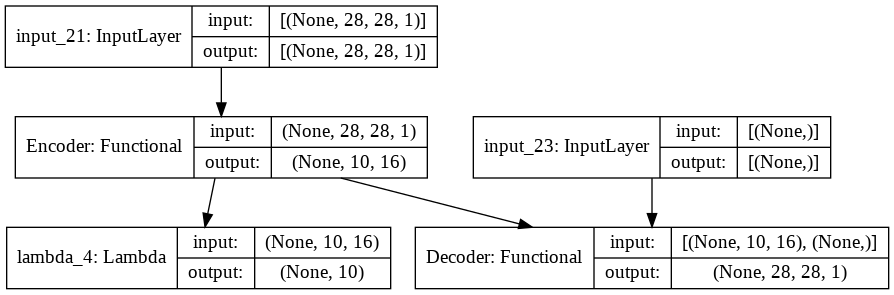

In [25]:
tf.keras.utils.plot_model(tmp, show_shapes = True)

In [26]:
del tmp

## **Compile & Fit**

In [10]:
class MarginLoss(tf.keras.losses.Loss):

    def __init__(
        self, 
        num_classes = 10,
        m_p = 0.9,
        m_m = 0.1,
        l = 0.5,
        name = None,
    ):
        super(MarginLoss, self).__init__(name = name)
        self.num_classes = 10
        self.m_p = 0.9
        self.m_m = 0.1
        self.down_weighting_factor = 0.5 ## Lambda


    def call(
        self, 
        y_true, 
        y_pred
    ):
        y_true = tf.one_hot(y_true, depth = self.num_classes)
        
        l_eq = tf.math.maximum(0., self.m_p - y_pred) ** 2
        r_eq = tf.math.maximum(0., y_pred - self.m_m) ** 2

        return y_true * l_eq + (1. - y_true) * r_eq * self.down_weighting_factor

In [27]:
## Define a callback function that applies to each model.
def get_callbacks(
    model_name,
):
    ## Checkpoint callback.
    ckpt_path = os.path.join("ckpt", model_name, "cp-{epoch:03d}-{val_loss:.4f}.ckpt")
    os.makedirs(os.path.dirname(ckpt_path), exist_ok = True)
    
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        ckpt_path, verbose = 0, monitor = "val_loss", save_weights_only = True, save_best_only = True)
    
    ## TensorBoard callback.
    log_dir = os.path.join("logs", "fit", model_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1, update_freq = "batch")
    
    return [cp_callback, tb_callback]

In [28]:
model = CapsNet(is_training = True)
model.compile(
    optimizer = "adam",
    loss = [MarginLoss(), tf.keras.losses.MSE],
    loss_weights = [1., 784 * 5e-4])

In [29]:
_ = model.fit(
    tr_dataset,
    validation_data = vl_dataset,
    verbose = 1,
    epochs = 20,
    callbacks = get_callbacks(model.name))

Epoch 1/20
49/49 [==============================] - 246s 5s/step - loss: 0.1488 - lambda_5_loss: 0.0722 - Decoder_loss: 0.1954 - val_loss: 0.0799 - val_lambda_5_loss: 0.0528 - val_Decoder_loss: 0.0691
Epoch 2/20
49/49 [==============================] - 241s 5s/step - loss: 0.0791 - lambda_5_loss: 0.0526 - Decoder_loss: 0.0678 - val_loss: 0.0773 - val_lambda_5_loss: 0.0524 - val_Decoder_loss: 0.0635
Epoch 3/20
49/49 [==============================] - 240s 5s/step - loss: 0.0766 - lambda_5_loss: 0.0524 - Decoder_loss: 0.0617 - val_loss: 0.0745 - val_lambda_5_loss: 0.0524 - val_Decoder_loss: 0.0564
Epoch 4/20
49/49 [==============================] - 240s 5s/step - loss: 0.0741 - lambda_5_loss: 0.0525 - Decoder_loss: 0.0553 - val_loss: 0.0726 - val_lambda_5_loss: 0.0525 - val_Decoder_loss: 0.0512
Epoch 5/20
49/49 [==============================] - 242s 5s/step - loss: 0.0724 - lambda_5_loss: 0.0526 - Decoder_loss: 0.0506 - val_loss: 0.0711 - val_lambda_5_loss: 0.0526 - val_Decoder_loss: 0.

In [ ]:
%tensorboard --logdir logs/fit/